In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('hits_1000.csv', index_col=False)
#data = data[data.event.values < 100]

data.head()

,event,particle,layer,iphi,x,y
0,0,0,5,39276,55.103343,-401.233874
1,0,6,5,22685,-381.682239,135.438799
2,0,3,3,6082,160.995866,139.460859
3,0,5,2,27787,-35.433651,-150.895515
4,0,5,1,15230,-19.627350,-82.702885


# Tracks Clustering

## One event

In [3]:
toy_event_id = 0
event = data[data.event.values == toy_event_id]

In [4]:
from hough import Hough

h = Hough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=6)
h.predict(event.x.values, event.y.values)

matrix_hough = h.matrix_hough_
track_inds = h.track_inds_
track_params = h.track_params_

In [5]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([19, 22, 28, 35, 48, 52]), array([19, 22, 28, 35, 48, 52]),
       array([19, 22, 28, 35, 48, 52]), array([13, 19, 22, 28, 48, 52]),
       array([13, 19, 22, 28, 35, 48, 52]),
       array([ 2,  5, 16, 36, 49, 56]), array([ 2,  5, 16, 36, 40, 49]),
       array([ 2,  5, 16, 36, 40, 49]), array([ 2,  5, 16, 36, 40, 49]),
       array([ 3, 23, 29, 30, 32, 54]),
       array([ 3, 23, 29, 30, 32, 43, 53, 54]),
       array([ 3, 23, 29, 30, 32, 43, 53, 54]),
       array([ 3, 23, 29, 30, 32, 43, 53, 54]),
       array([23, 29, 30, 32, 43, 53, 54]),
       array([23, 29, 30, 32, 43, 54]), array([17, 23, 33, 39, 45, 50]),
       array([17, 18, 23, 30, 33, 39, 50]),
       array([17, 18, 23, 30, 33, 39, 50]),
       array([17, 18, 23, 30, 33, 39, 50]),
       array([17, 23, 30, 33, 39, 50]), array([17, 23, 30, 33, 39, 50]),
       array([ 0,  9, 14, 34, 38, 42]), array([ 0,  9, 14, 34, 38, 42]),
       array([ 0,  9, 14, 26, 34, 38, 42]),
       array([ 0,  9, 14, 26, 34, 38, 42]

The following function merge hits of track from one cluster.

In [6]:
def merge_tracks(tracks_inds, cluster_labels):
    
    new_track_inds = []
    
    for one_label in numpy.unique(cluster_labels):
        
        one_label_tracks = tracks_inds[cluster_labels == one_label]
        one_new_track = numpy.unique(numpy.concatenate(tuple(one_label_tracks)))
        
        new_track_inds.append(one_new_track)
        
    return numpy.array(new_track_inds)

Tracks clustering and merging hit of tracks from one cluster.

In [7]:
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled_params = ss.fit_transform(numpy.array(track_params))

km = MeanShift(bandwidth=0.1)
km.fit(scaled_params)

cluster_labels = km.labels_
cluster_centers = km.cluster_centers_

new_track_inds = merge_tracks(track_inds, cluster_labels)

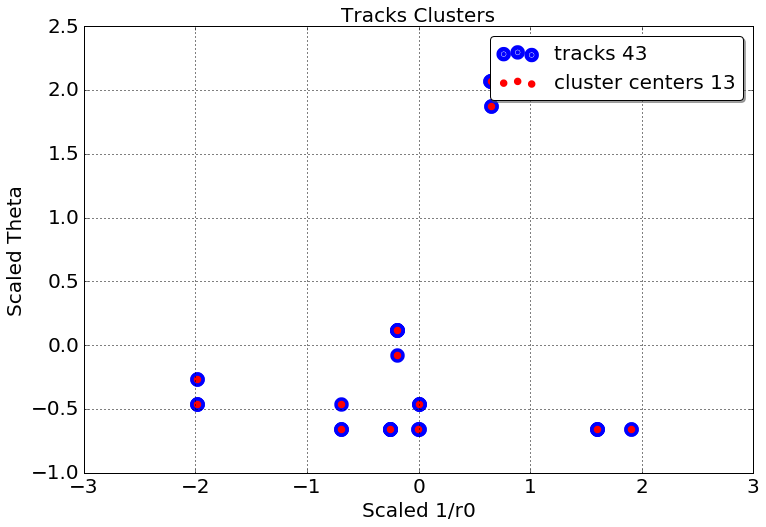

In [8]:

plt.figure(figsize=(12,8))
plt.scatter(scaled_params[:, 0], scaled_params[:, 1], color='b', label='tracks %d' % len(scaled_params), linewidth=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='r', label='cluster centers %d' % len(cluster_centers), linewidth=3)

plt.title("Tracks Clusters", fontsize=20)
plt.legend(loc="best", prop={'size':20},  shadow=True, fancybox=True)
plt.xlabel('Scaled 1/r0', fontsize=20)
plt.ylabel('Scaled Theta', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linewidth=1)
plt.show()

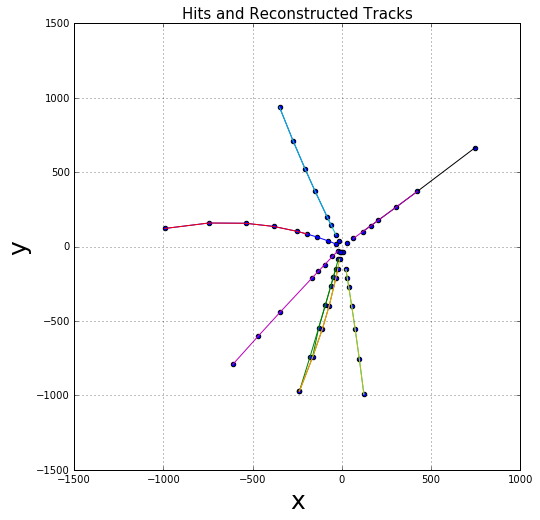

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(event.x.values, event.y.values)

for track in new_track_inds:
    
    xs = event.x.values[track]
    ys = event.y.values[track]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Reconstructed Tracks", size=15)
plt.xlabel("x", size=25)
plt.ylabel("y", size=25)
plt.grid(b=1)
plt.show()

## Hough Transform Modification

In [10]:
from hough import Hough
from regression import TrackRegression
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

class ModifiedHough(Hough):
    
    
    def __init__(self, n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=7, bandwidth=0.1):
        
        self.bandwidth = bandwidth # Parameters affects the tracks clustering quality
        
        Hough.__init__(self, n_theta_bins, n_radius_bins, min_radius, min_hits)
    
    def merge_tracks(tracks_inds, cluster_labels):
    
        new_track_inds = []

        for one_label in numpy.unique(cluster_labels):

            one_label_tracks = tracks_inds[cluster_labels == one_label]
            one_new_track = numpy.unique(numpy.concatenate(tuple(one_label_tracks)))

            new_track_inds.append(one_new_track)

        return numpy.array(new_track_inds)
    
    def tracks_clustering(self, track_inds, track_params):
        
        ss = StandardScaler()
        scaled_params = ss.fit_transform(numpy.array(track_params))

        km = MeanShift(bandwidth=self.bandwidth)
        km.fit(scaled_params)

        cluster_labels = km.labels_
        cluster_centers = km.cluster_centers_

        new_track_inds = merge_tracks(track_inds, cluster_labels)
        
        return new_track_inds

    
    def predict(self, x, y): # This method must be!
        
        Hough.predict(self, x, y)
        
        self.track_inds_ = self.tracks_clustering(self.track_inds_, self.track_params_) # This attribute must be!

In [11]:
from recognizer import TrackRecognizer

method = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=6, bandwidth=0.001)

tr = TrackRecognizer(method=method)
results = tr.predict(data)

results.head()

,event,track,hit_index,x,y
0,0,0,3,-35.433651,-150.895515
1,0,0,23,-237.993471,-971.266754
2,0,0,29,-178.767664,-740.733503
3,0,0,30,-242.167696,-970.234408
4,0,0,32,-93.036300,-394.169059


## Quality metrics

In [12]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data, results, track_eff_threshold=0.8, min_hits_per_track=6)
report_event, report_tracks = rq.calculate()

In [13]:
report_event.mean(axis=0)

Event                       499.500000
ReconstructionEfficiency      0.919417
GhostRate                     0.465082
CloneRate                     1.707201
AvgTrackEfficiency            0.931230
dtype: float64